In [ ]:
import h5py
import mne
from eegatscale.models import LinearHeadBENDR
from scripts.finetune_cv import H5PYDatasetLabeled
from scripts.finetune_cv_nogroups import H5PYDatasetLabeled as H5PYDatasetLabeledNoGroups
from torch.utils.data import DataLoader
from eegatscale.transforms import StandardizeLabel, Standardize
import numpy as np
import torch
import pickle
from dataset_utils import PickleDataset
from glob import glob

In [ ]:
# get th

In [ ]:
mmidb_own_path = "/scratch/s194101/data/preprocessed_downstream/mmidb/mmidb_noica_5.0_titans_combined/"
mmidb_path = "/scratch/agjma/preprocess_downstream_mmidb_noica_5.0_combined/"
file_name = "combined_00000.hdf5"
# file_name = "data_1.hdf5"

# file = h5py.File(mmidb_own_path + file_name, 'r')
transform = StandardizeLabel()
mmidb_dataset_own = H5PYDatasetLabeled(mmidb_own_path, transform=transform)
mmidb_dataset = H5PYDatasetLabeledNoGroups(mmidb_path, transform=transform)



In [ ]:
file.keys()
# file['file_idxs']

In [ ]:
# test_index = np.loadtxt("test_index.txt", dtype=int)
# train_index = np.loadtxt("train_index.txt", dtype=int)

# train_dataset = torch.utils.data.Subset(dataset, train_index)
# test_dataset = torch.utils.data.Subset(dataset, test_index)

# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

dataloader_mmidb_own = DataLoader(mmidb_dataset_own, batch_size=len(mmidb_dataset), shuffle=True)
dataloader_mmidb = DataLoader(mmidb_dataset, batch_size=len(mmidb_dataset), shuffle=True)



In [ ]:
print("MMIDB dataset own")
x, y = next(iter(dataloader_mmidb_own))
print(x.shape)
x.mean(), x.std(), x.min(), x.max()

In [ ]:
print("MMIDB dataset")
x, y = next(iter(dataloader_mmidb))
print(x.shape)
x.mean(), x.std(), x.min(), x.max()

In [ ]:
# get the channels in the file
file.keys()

In [ ]:
sample_data = file["data"][0:16].shape
sample_data = torch.from_numpy(file["data"][0:16])
sample_data.shape

In [ ]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"
# encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_nogroups_2/version_0/checkpoints/epoch=2-step=756.ckpt"
# encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_nogroups/version_22/checkpoints/epoch=7-step=2016.ckpt"
# encoder_path = ""

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
temp_state_dict = model.state_dict()
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")


In [54]:
def test_model(model, dataloader):

    accs = []
    for i, batch in enumerate(dataloader):
        x, y = batch
        z = model(x)
        acc = (z.argmax(dim=1) == y).float().mean()
        accs.append(acc)

    return accs
print("MMIDB own")
accs = test_model(model, dataloader_mmidb_own)
print(np.mean(accs))

print("MMIDB")
accs = test_model(model, dataloader_mmidb)
print(np.mean(accs))

0.7524677
MMIDB
0.79821825


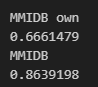

In [ ]:
file.keys()

In [ ]:
# file["labels"][:]
file["data"][0:2].shape
# file["time_slices"]

# file

In [ ]:
model(sample_data)

In [ ]:
# file["sessions_labels"]
# file["time_slices"]

In [ ]:
# open raw edf file
# raw = mne.io.read_raw_edf("data/mmidb/files/s003/s003R01.edf")
raw = mne.io.read_raw_edf("/scratch/agjma/eegmmidb/files/S003/S003R03.edf")
raw



In [ ]:
# get filename of the raw file
# raw.annotations

# get the labels
annotation = raw.annotations
annotation.onset

In [ ]:
filename = "/scratch/agjma/eegmmidb/files/S101/S101R07.edf"

In [ ]:
filename.split("/")[-2]

# Loading of PickleDataset

In [ ]:
dataset = PickleDataset("/scratch/s194101/concepts/random_left_concept_MMIDB_Alpha_sanity_check")
len(dataset)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000)

# model tests for tcav

In [ ]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"
# encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_nogroups_2/version_0/checkpoints/epoch=2-step=756.ckpt"
# encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_nogroups/version_22/checkpoints/epoch=7-step=2016.ckpt"
# encoder_path = ""

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

In [ ]:
names = list(model._modules.keys())
layers = list(model.children())

print(len(names), len(layers))

In [ ]:
# for name, layer in zip(names, layers):
#     print(name, layer)

# Test whether the concepts look the same for the mmidb and tuh

In [ ]:
mmidb_files_dir = "/scratch/s194101/concepts/random_mmidb_alpha_new"
tuh_files_dir = "/scratch/s194101/concepts/random_tuh_alpha"

mmidb_files = glob(f"{mmidb_files_dir}/*.pkl")
print(f"{len(mmidb_files)=}")

tuh_files = glob(f"{tuh_files_dir}/*.pkl")
print(f"{len(tuh_files)=}")

with open(mmidb_files[0], "rb") as f:
    data_mmidb = pickle.load(f)
print(f"{data_mmidb.shape=}")

with open(tuh_files[0], "rb") as f:
    data_tuh = pickle.load(f)
print(f"{data_tuh.shape=}")


In [ ]:
# len(data_tuh.shape)

mmidb_dataset = PickleDataset(mmidb_files_dir)
print(f"{len(mmidb_dataset)=}")
tuh_dataset = PickleDataset(tuh_files_dir)
print(f"{len(tuh_dataset)=}")

In [ ]:
mmidb_dataset[0].dtype
tuh_dataset[0].dtype

# Test what the TUEV dataset looks like

In [ ]:
import h5py
import numpy as np

In [ ]:
# file_path = "/scratch/s194101/data/preprocessed_downstream/tuev/noica_5.0_titans_combine_test_debug_combined/combined_00000.hdf5"
file_path = "/scratch/s194101/data/preprocessed_downstream/tusz/noica_60.0_titans_combine_test_debug_combined/combined_00000.hdf5"

file = h5py.File(file_path, 'r')
file.keys()

In [ ]:
file.attrs.keys()

In [ ]:
file["data"][:].shape

In [ ]:
file["sessions_labels"][:]

In [ ]:
np.unique(file["sessions_labels"][:])

In [ ]:
test_file_path = "/scratch/s194101/data/preprocessed_downstream/tusz/noica_5.0_titans_combine_test_debug_3/data_1.hdf5"


test_file = h5py.File(test_file_path, 'r')
test_file.keys()

In [ ]:
test_file["data"][:].shape